<a href="https://colab.research.google.com/github/Fahmidanishi/COVID-19-Recovery-Predictor-using-Random-forest/blob/main/COVID_19_Recovery_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip -q install gradio scikit-learn pandas numpy matplotlib

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)
import gradio as gr

In [ ]:
CSV_PATH = "/content/COVID-19_CBC_Data.csv"
RANDOM_STATE = 42
TEST_SIZE = 0.2

df = pd.read_csv(CSV_PATH)
# Clean column names (strip spaces)
df.columns = df.columns.str.strip()

In [ ]:
# Check missing values
df.isnull().sum()


,0
Admission_DATE,0
Discharge_DATE or date of Death,0
Outcome,0
Patient Age,0
Gender,0
Sample Collection Date,0
What kind of Treatment provided,0
Ventilated (Y/N),0
Red blood cell distribution width,0
Monocytes(%),0


In [ ]:

# Normalize names we’ll use
rename_map = {
    "Outcome": "outcome",
    "Patient Age": "age",
    "Gender": "gender",
    "Ventilated (Y/N)": "ventilated",
    "What kind of Treatment provided": "treatment",
    "What kind of Treatment provided ": "treatment",
    "Red blood cell distribution width": "rdw",
    "Monocytes(%)": "monocytes_pct",
    "White blood cell count": "wbc",
    "Platelet Count": "platelets",
    "Lymphocyte Count": "lymphocytes",
    "Neutrophils Count": "neutrophils",
    # dates (we'll drop for modeling)
    "Admission_DATE": "admission_date",
    "Admission_DATE ": "admission_date",
    "Discharge_DATE or date of Death": "discharge_or_death_date",
    "Sample Collection Date": "sample_collection_date",
    "Sample Collection Date ": "sample_collection_date",
}
df = df.rename(columns={k: v for k, v in rename_map.items() if k in df.columns})

assert "outcome" in df.columns, "Outcome column not found."

# Drop irrelevant date cols
drop_cols = [c for c in ["admission_date","discharge_or_death_date","sample_collection_date"] if c in df.columns]
df = df.drop(columns=drop_cols, errors="ignore")


In [ ]:
# Feature set
candidate_features = [
    "age","gender","ventilated","treatment",
    "rdw","monocytes_pct","wbc","platelets","lymphocytes","neutrophils"
]
FEATURE_COLS = [c for c in candidate_features if c in df.columns]

X = df[FEATURE_COLS].copy()
y = df["outcome"].astype(str)

In [ ]:
# sanity check
print("\n After cleaning:")
print(f"Rows: {len(df)} | Features used: {FEATURE_COLS}")
print(f"Classes: {sorted(y.unique().tolist())}")


 After cleaning:
Rows: 103 | Features used: ['age', 'gender', 'ventilated', 'treatment', 'rdw', 'monocytes_pct', 'wbc', 'platelets', 'lymphocytes', 'neutrophils']
Classes: ['Not Recovered', 'Recovered']


In [ ]:
#  Encode categoricals

numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in FEATURE_COLS if c not in numeric_cols]

X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=False)
MODEL_COLUMNS = X_encoded.columns.tolist()

In [ ]:
#  Train/test split (80/20)

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)


=== Test Metrics ===
Accuracy : 0.9524
Precision: 1.0000
Recall   : 0.9167
F1-score : 0.9565
ROC AUC  : 1.0000

Classification Report:
               precision    recall  f1-score   support

Not Recovered       0.90      1.00      0.95         9
    Recovered       1.00      0.92      0.96        12

     accuracy                           0.95        21
    macro avg       0.95      0.96      0.95        21
 weighted avg       0.96      0.95      0.95        21



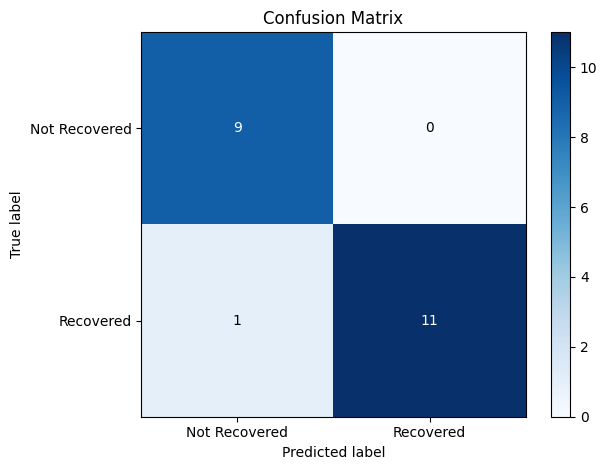

In [ ]:
#  Train Random Forest

clf = RandomForestClassifier(
    n_estimators=300,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
clf.fit(X_train, y_train)

#  Evaluation

y_pred = clf.predict(X_test)
print("\n=== Test Metrics ===")
print(f"Accuracy : {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred, pos_label='Recovered', zero_division=0):.4f}")
print(f"Recall   : {recall_score(y_test, y_pred, pos_label='Recovered', zero_division=0):.4f}")
print(f"F1-score : {f1_score(y_test, y_pred, pos_label='Recovered', zero_division=0):.4f}")

# ROC AUC if 2 classes
try:
    proba = clf.predict_proba(X_test)
    if len(clf.classes_) == 2:
        idx = list(clf.classes_).index("Recovered")
        y_bin = (y_test == "Recovered").astype(int)
        print(f"ROC AUC  : {roc_auc_score(y_bin, proba[:, idx]):.4f}")
except Exception:
    pass

print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0, target_names=["Not Recovered","Recovered"]))

# Confusion Matrix plot
cm = confusion_matrix(y_test, y_pred, labels=["Not Recovered","Recovered"])
plt.figure()
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks([0,1], ["Not Recovered","Recovered"])
plt.yticks([0,1], ["Not Recovered","Recovered"])
thresh = cm.max()/2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i,j], ha='center', va='center',
                 color='white' if cm[i,j] > thresh else 'black')
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()


In [ ]:
#  Gradio UI — dataset column names as labels


num_defaults = {c: float(np.median(X[c])) for c in numeric_cols if c in X.columns}

if "age" in FEATURE_COLS:
    age_min, age_max = float(np.floor(X["age"].min())), float(np.ceil(X["age"].max()))
    age_default = float(np.median(X["age"]))
else:
    age_min, age_max, age_default = 0.0, 100.0, 50.0

vent_choices = sorted(df["ventilated"].astype(str).str.strip().unique().tolist()) \
               if "ventilated" in FEATURE_COLS and "ventilated" in df.columns else None

def _align_like_training(single_df: pd.DataFrame) -> pd.DataFrame:
    for c in numeric_cols:
        if c in single_df.columns:
            single_df[c] = pd.to_numeric(single_df[c], errors="coerce")
    for c in categorical_cols:
        if c in single_df.columns:
            single_df[c] = single_df[c].astype(str).str.strip()

    present_cats = [c for c in categorical_cols if c in single_df.columns]  #one hot encoding
    if present_cats:
        single_enc = pd.get_dummies(single_df, columns=present_cats, drop_first=False)
    else:
        single_enc = single_df.copy()
    for col in MODEL_COLUMNS:
        if col not in single_enc.columns:
            single_enc[col] = 0
    single_enc = single_enc[MODEL_COLUMNS]
    return single_enc

def _safe_num(x, default):
    try:
        v = float(x)
        if not np.isfinite(v): return default
        return v
    except (TypeError, ValueError):
        return default

with gr.Blocks(title="COVID-19 Recovery Predictor") as demo:
    gr.Markdown("<h1 style='text-align:center'>COVID-19 Recovery Predictor</h1>")
    gr.Markdown("Enter values from the dataset columns.")

    with gr.Row():
        with gr.Column(scale=1):
            comps, order = {}, []

            if "age" in FEATURE_COLS:
                comps["age"] = gr.Slider(minimum=age_min, maximum=age_max, step=1,
                                         value=age_default, label="age")
                order.append("age")
            if "wbc" in FEATURE_COLS:
                comps["wbc"] = gr.Number(label="wbc", value=num_defaults.get("wbc", 0.0)); order.append("wbc")
            if "lymphocytes" in FEATURE_COLS:
                comps["lymphocytes"] = gr.Number(label="lymphocytes", value=num_defaults.get("lymphocytes", 0.0)); order.append("lymphocytes")
            if "neutrophils" in FEATURE_COLS:
                comps["neutrophils"] = gr.Number(label="neutrophils", value=num_defaults.get("neutrophils", 0.0)); order.append("neutrophils")
            if "platelets" in FEATURE_COLS:
                comps["platelets"] = gr.Number(label="platelets", value=num_defaults.get("platelets", 0.0)); order.append("platelets")
            if "rdw" in FEATURE_COLS:
                comps["rdw"] = gr.Number(label="rdw", value=num_defaults.get("rdw", 0.0)); order.append("rdw")
            if "monocytes_pct" in FEATURE_COLS:
                comps["monocytes_pct"] = gr.Number(label="monocytes_pct", value=num_defaults.get("monocytes_pct", 0.0)); order.append("monocytes_pct")
            if "ventilated" in FEATURE_COLS and vent_choices:
                comps["ventilated"] = gr.Dropdown(choices=vent_choices, value=vent_choices[0], label="ventilated")
                order.append("ventilated")

            submit_btn = gr.Button("Submit", variant="primary")
            clear_btn  = gr.Button("Clear Output")

        with gr.Column(scale=1):
            result = gr.JSON(label="Result")

    inputs_list = [comps[n] for n in order]

    def predict_dynamic(*vals):
        row = {order[i]: vals[i] for i in range(len(order))}
        for c in numeric_cols:
            if c in row:
                row[c] = _safe_num(row[c], num_defaults.get(c, 0.0))
        for c in categorical_cols:
            if c in row:
                row[c] = str(row[c]).strip()
        X_new = _align_like_training(pd.DataFrame([row]))
        pred = clf.predict(X_new)[0]
        conf_rec = None
        try:                   #confidence for recovered
            probs = clf.predict_proba(X_new)[0]
            prob_map = {cls: float(np.round(p, 4)) for cls, p in zip(clf.classes_, probs)}
            conf_rec = prob_map.get("Recovered", None)
        except Exception:
            pass
        out = {"Prediction": pred}
        if conf_rec is not None:
            out["Confidence_Recovered"] = conf_rec
        return out

    submit_btn.click(fn=predict_dynamic, inputs=inputs_list, outputs=result)
    clear_btn.click(fn=lambda: {}, outputs=result)

demo.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://50bc71db356631c067.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
